<H1>10,000 USD worth of TKN invested in the Omnipool for one year</H1>

<H3>Effects of trade volume.</H3>
Trade volume generates fees, which are the primary way of offsetting IL. We'll assume prices do no change, so there is no impermanent loss. Trade volume goes from 0% to 5% of TVL per day. (So far we have observed ~1% on average.) We also assume 0.3% total fees. We fully simulate one month and then extrapolate the results to one year. This should still be fairly accurate, because of the linear nature of the correlation between time and profit, but it does introduce a small amount of uncertainty.

In [1]:
import random
import sys
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run, plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, usd_price, lrna_price, value_assets, execute_remove_liquidity
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading, back_and_forth
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices, ArchiveState

# same seed, same parameters = same simulation result
random.seed(42)
price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 30)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.05},
    'USD': {'usd price': 1, 'weight': 0.20},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.50},
    'DOT': {'usd price': 1, 'weight': 0.17},
    'TKN': {'usd price': 1, 'weight': 0.03}
}

lrna_price_usd = 1
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}
asset_fee = 0.0025
lrna_fee = 0.0005

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            asset_fee=0.0025,
            lrna_fee=0.0005,
            withdrawal_fee=False
        )
    },
    agents = {
        'Trader': Agent(
            holdings={tkn: 10000000 for tkn in list(assets.keys()) + ['LRNA']}
        ),
        'LP': Agent(
            holdings={'TKN': 10000},
            trade_strategy=invest_all('omnipool')
        ),
        # 'LP2': Agent(
        #     holdings={'DOT': 10000},
        #     trade_strategy=invest_all('omnipool')
        # )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all=False
)

# copy DOT prices for TKN
# for j, step in enumerate(price_list):     
#     step['TKN'] = step['DOT'] / price_list[0]['DOT']

In [2]:
time_steps = 219000  # int(7200 * 365 / 12)
volume_events = []
trade_volume = []
semi_final_state = []
final_state = []
# initial_state._evolve_function = historical_prices(price_list)
for i in range(6):
    initial_state.agents['Trader'].trade_strategy=back_and_forth(
        pool_id='omnipool',
        percentage=i / 360000 / (1 - asset_fee - lrna_fee)
    ) if i > 0 else None
    events = run.run(initial_state, time_steps)
    
    trade_volume.append({tkn: (sum([event.pools['omnipool'].volume_out[tkn] 
                                    / event.pools['omnipool'].liquidity[tkn] for event in events])
        / time_steps * 7200) for tkn in assets}
    )
    print('Trade volume per day as a fraction of TVL:', trade_volume[i])

    volume_events.append(events[::200])
    volume_events[-1].append(events[-1])
    
    del events

Starting simulation...
Execution time: 38.873 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 0.0, 'USD': 0.0, 'BTC': 0.0, 'ETH': 0.0, 'DOT': 0.0, 'TKN': 0.0}
Starting simulation...
Execution time: 88.07 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 0.010000012495836826, 'USD': 0.010000012502803262, 'BTC': 0.010000012502803355, 'ETH': 0.010000012502801739, 'DOT': 0.010000012502803362, 'TKN': 0.010000011029834038}
Starting simulation...
Execution time: 88.528 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 0.02000002490813006, 'USD': 0.02000002493598734, 'BTC': 0.02000002493598931, 'ETH': 0.020000024935990127, 'DOT': 0.020000024935989045, 'TKN': 0.020000021990042104}
Starting simulation...
Execution time: 87.708 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 0.030000037236865996, 'USD': 0.030000037299553438, 'BTC': 0.030000037299554354, 'ETH': 0.030000037299554885, 'DOT': 0.030000037299555186, 'TKN': 0.030000032880643755}
Starting simul

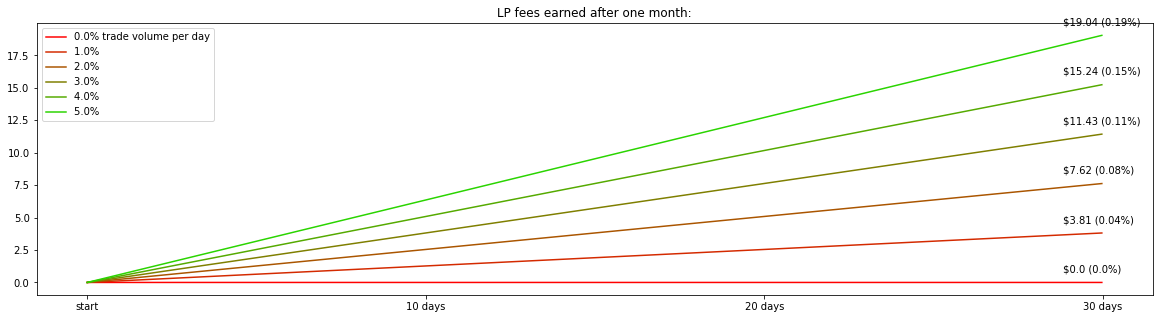

In [3]:
plt.figure(figsize=(20, 5))
plt.title('LP fees earned after one month:')
graph_length = len(volume_events[1])
plt.xticks(
    [0, graph_length / 3, graph_length / 1.5, graph_length],
    ['start', '10 days', '20 days', '30 days']
)
colors = pu.color_gradient(length=6, color1=(255, 0, 0), color2=(0, 255, 0))
baseline =[value_assets(event.external_market, initial_state.agents['LP'].holdings) for event in volume_events[0]]
# [0] * len(volume_events[0])
# [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in volume_events[0]]
volume_returns = [
    [
        (cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market)
        - baseline[i])  # extend to one year
        for i, event in enumerate(events)
    ]
    for events in volume_events
]

for i, scenario in enumerate(volume_returns):
    plt.plot(range(len(scenario)), scenario, color=colors[i])
    plt.annotate(
        f'${round(scenario[-1], 2)} ({round(scenario[-1] / 100, 2)}%)', 
        xy=(len(scenario), scenario[-1]), xytext=(-40, 10), textcoords='offset points'
    )

plt.legend([
    f'{round(volume["TKN"] * 100, 1)}% {("trade volume per day") if volume["TKN"] == 0 else ""}' 
    for volume in trade_volume
])


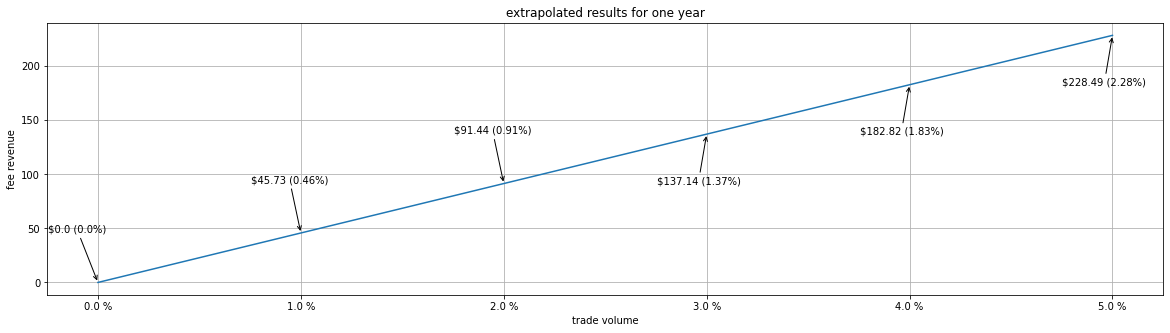

In [4]:
plt.figure(figsize=(20, 5))
plt.title('extrapolated results for one year')
plt.xticks(
    [volume["TKN"] for volume in trade_volume],
    [f'{round(volume["TKN"] * 100, 2)} %'  for volume in trade_volume]
)
points = [(trade_volume[i]['TKN'], volume_returns[i][-1] * 12) for i in range(len(trade_volume))]
for i, coors in enumerate(points):
    plt.annotate(
        text=f'${round(coors[1], 2)} ({round(coors[1] / 100, 2)}%)',
        xy=coors,
        xytext=(-50, 50) if i < len(points) / 2 else (-50, -50),
        textcoords='offset points',
        arrowprops={
            'arrowstyle': '->'
        }
    )
plt.xlabel('trade volume')
plt.ylabel('fee revenue')
plt.grid()
plt.plot([volume["TKN"] for volume in trade_volume], [scenario[-1] * 12 for scenario in volume_returns])

In [5]:
initial_state.agents['LP'].asset_list

['TKN']